In [46]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import string
import seaborn as sns

import scipy as sp
from scipy import sparse
import sklearn
import umap

## add your packages ##

import time
import pickle
import memory_profiler
from collections import Counter
import matplotlib.colors as mcolors

%load_ext memory_profiler

from pathlib import Path

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [47]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [48]:
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
data_path = Path("../datX")

In [49]:
plt.style.use("matplotlib_style.txt")

In [50]:
np.random.seed(42)

# Data

We are going to use the multimodal data from the paper Scala et al. 2021 (https://www.nature.com/articles/s41586-020-2907-3#Sec7). In particular, you will work with transcriptomics and electrophysiological data. From the transcriptomics gene counts, we will only work with the exon counts for simplicity. Some of the electrophysiological features are not high-quality recordings, therefore we will also filter them out for the project.

## Import

### Meta data

In [51]:
# META DATA

meta = pd.read_csv("data/m1_patchseq_meta_data.csv", sep="\t")

cells = meta["Cell"].values

layers = meta["Targeted layer"].values.astype("str")
cre = meta["Cre"].values
yields = meta["Yield (pg/µl)"].values
yields[yields == "?"] = np.nan
yields = yields.astype("float")
depth = meta["Soma depth (µm)"].values
depth[depth == "Slice Lost"] = np.nan
depth = depth.astype(float)
thickness = meta["Cortical thickness (µm)"].values
thickness[thickness == 0] = np.nan
thickness = thickness.astype(float)
traced = meta["Traced"].values == "y"
exclude = meta["Exclusion reasons"].values.astype(str)
exclude[exclude == "nan"] = ""

mice_names = meta["Mouse"].values
mice_ages = meta["Mouse age"].values
mice_cres = np.array(
    [
        c if c[-1] != "+" and c[-1] != "-" else c[:-1]
        for c in meta["Cre"].values
    ]
)
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print("Number of cells with measured depth:    ", np.sum(~np.isnan(depth)))
print("Number of cells with measured thickness:", np.sum(~np.isnan(thickness)))
print("Number of reconstructed cells:          ", np.sum(traced))

sliceids = meta["Slice"].values
a, b = np.unique(sliceids, return_counts=True)
assert np.all(b <= 2)
print("Number of slices with two cells:        ", np.sum(b == 2))

# Some consistency checks
assert np.all(
    [
        np.unique(meta["Date"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse age"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse gender"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse genotype"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse"].values[sliceids == s]).size == 1
        for s in sliceids
    ]
)

Number of cells with measured depth:     1284
Number of cells with measured thickness: 1284
Number of reconstructed cells:           646
Number of slices with two cells:         69


### Transcriptomic data

In [52]:
# READ COUNTS

data_exons = pd.read_csv(
    "data/m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)
exonCounts = data_exons.values.transpose()

assert all(cells == data_exons.columns)
genes = np.array(data_exons.index)

print("Count matrix shape (exon):  ", exonCounts.shape)

Count matrix shape (exon):   (1329, 42466)


In [53]:
data_exons

,20171204_sample_2,20171204_sample_4,20171204_sample_5,20171204_sample_6,20171207_sample_1,20171207_sample_2,20171207_sample_6,20171207_sample_7,20171219_sample_1,20171219_sample_2,...,20191114_sample_9,20200106_sample_1,20200106_sample_4,20200106_sample_5,20200106_sample_6,20200225_sample_2,20200225_sample_5,20200316_sample_1,20200316_sample_2,20200316_sample_3
0610005C13Rik,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
0610006L08Rik,0,0,0,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610009B22Rik,0,68,1291,0,0,0,227,0,7,10,...,0,271,0,0,0,0,138,0,78,89
0610009E02Rik,0,0,0,0,30,80,205,0,0,14,...,0,0,0,0,0,0,1,0,0,0
0610009L18Rik,0,0,0,0,0,99,0,380,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-TSaga9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
# GENE LENGTH

data = pd.read_csv("data/gene_lengths.txt")
assert all(data["GeneID"] == genes)
exonLengths = data["exon_bp"].values
intronLengths = data["intron_bp"].values

### Cluster colors

In [55]:
cluster_colors = np.load("data/cluster_colors.npy")

In [56]:
cluster_colors.shape

(1329,)

In [57]:
rna_type = np.load("data/rna_type.npy", allow_pickle=True)

In [58]:
rna_type.shape

(1329,)

In [59]:
pickle_in = open("data/dict_rna_type_colors.pkl", "rb")
dict_rna_type_colors = pickle.load(pickle_in)

In [60]:
len(dict_rna_type_colors)

88

### Electrophysiological features

In [61]:
# EPHYS DATA

ephysData = pd.read_csv("data/m1_patchseq_ephys_features.csv")
ephysNames = np.array(ephysData.columns[1:]).astype(str)
ephysCells = ephysData["cell id"].values
ephysData = ephysData.values[:, 1:].astype("float")
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array(
    [
        names2ephys[c] if c in names2ephys else ephysData[0] * np.nan
        for c in cells
    ]
)

print("Number of cells with ephys data:", np.sum(np.isin(cells, ephysCells)))

assert np.sum(~np.isin(ephysCells, cells)) == 0

Number of cells with ephys data: 1328


In [62]:
# Filtering ephys data

features_exclude = [
    "Afterdepolarization (mV)",
    "AP Fano factor",
    "ISI Fano factor",
    "Latency @ +20pA current (ms)",
    "Wildness",
    "Spike frequency adaptation",
    "Sag area (mV*s)",
    "Sag time (s)",
    "Burstiness",
    "AP amplitude average adaptation index",
    "ISI average adaptation index",
    "Rebound number of APs",
]
features_log = [
    "AP coefficient of variation",
    "ISI coefficient of variation",
    "ISI adaptation index",
    "Latency (ms)",
]

X = ephysData
print(X.shape)
for e in features_log:
    X[:, ephysNames == e] = np.log(X[:, ephysNames == e])
X = X[:, ~np.isin(ephysNames, features_exclude)]

keepcells = ~np.isnan(np.sum(X, axis=1))
X = X[keepcells, :]
print(X.shape)
X = X - X.mean(axis=0)
ephysData_filtered = X / X.std(axis=0)

(1329, 29)
(1320, 17)


In [63]:
np.sum(np.isnan(ephysData_filtered))

0

# Research questions to investigate

**1) Inspect the data computing different statistics.** Keep in mind that the data is read counts, not UMI, so it is not supposed to follow a Poisson distribution.

**2) Normalize and transform the data.** There are several ways of normalizing the data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization.

**3) Two-dimensional visualization.** Try different methods (t-SNE, UMAP) / parameters (exagg., perplex.) for visualizations. Compare them using quantitative metrics (e.g., distance correlation, kNN accuracy/recall in high-dim vs. two-dim). Think about also using the electrophysiological features for different visualizations.

**4) Clustering.** Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2) and S (set of important genes). Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

**5) Correlation in between electrophysiological features and genes/PCs.** Find correlations and a way of visualizing them.
    

### Introduction

## 1) Inspect The Data ##

### Meta data

In [64]:
# number of mice
mouse_all = meta["Mouse"].values.astype("str")
n_mice = len(np.unique(mouse_all))
print(f"The dataset consists of {n_mice} different mice.")

The dataset consists of 266 different mice.


In [65]:
# Gender
mouse_genders = meta["Mouse gender"].values.astype("str")
genders, gender_counts = np.unique(mouse_genders, return_counts=True)
percentages_gender = {
    gender: (count / len(mouse_genders)) * 100
    for gender, count in zip(genders, gender_counts)
}

for gender, percentage in percentages_gender.items():
    print(f"Percentage of {gender} mice: {percentage:.2f}%")

Percentage of F mice: 51.47%
Percentage of M mice: 48.53%


In [66]:
# Genotype
mouse_genotypes = meta["Mouse genotype"].values.astype("str")
genotype_counts = Counter(mouse_genotypes)
genotype_percentages = {
    genotype: (count / len(mouse_genotypes)) * 100
    for genotype, count in genotype_counts.items()
}
print(genotype_percentages)

# Combine all genotypes with less than 5%
genotype_summary = {
    k: v
    for k, v in genotype_counts.items()
    if v >= 0.05 * len(mouse_genotypes)
}
other_genotypes_count = sum(
    v for k, v in genotype_counts.items() if v < 0.05 * len(mouse_genotypes)
)
genotype_summary["Other genotypes"] = other_genotypes_count

# Custom colormap
cmap = plt.get_cmap("Blues")
norm = mcolors.Normalize(vmin=0, vmax=len(genotype_summary))
colors = [cmap(norm(i)) for i in range(len(genotype_summary))]

{'Pvalb-Cre/wt; Ai9/wt': 29.044394281414597, 'Sst-IRES-Cre/wt; Ai9/wt': 28.74341610233258, 'Viaat-Cre/wt; Ai9/wt': 8.577878103837472, 'wt/wt': 9.029345372460497, 'Scnn1a-Tg3-Cre/wt; Ai9/wt': 0.07524454477050413, 'Vip-IRES-Cre/wt; Ai9/wt': 17.155756207674944, 'Vipr2-IRES2-Cre-D/wt; Ai9/wt': 3.235515425131678, 'Slc17a8-IRES2-Cre-D/wt; Ai9/wt': 2.784048156508653, 'Npy-Cre/wt; Ai9/wt': 0.6772009029345373, 'Vglut3-Cre/wt; Ai9/wt': 0.4514672686230248, 'Gnb4-IRES2-CreER2-D knock-in/wt; Ai9/wt': 0.2257336343115124}


In [67]:
# Age
mouse_ages = list(mice_ages.values())
mean_age = np.mean(mouse_ages)

In [68]:
# Normalized soma depth
filtered_thickness = thickness[~np.isnan(thickness) & ~np.isnan(depth)]
filtered_depth = depth[~np.isnan(thickness) & ~np.isnan(depth)]

# Normalize depth by thickness
normalized_depth = filtered_depth / filtered_thickness
mean_depth = np.mean(normalized_depth)

/var/folders/5j/y5kkrfqd203frqztz88nnmqr0000gn/T/ipykernel_62497/1631768841.py:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


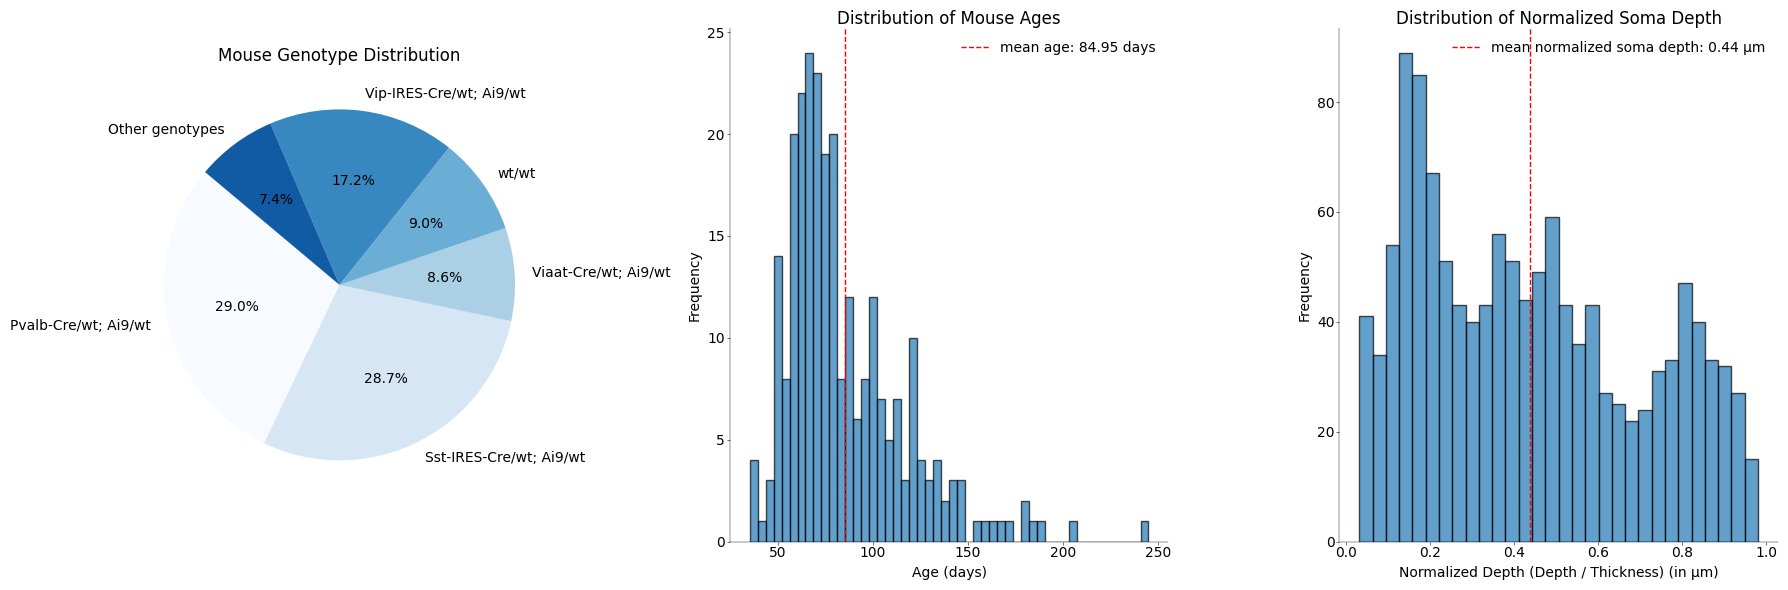

In [69]:
# Plot
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.pie(
    genotype_summary.values(),
    labels=genotype_summary.keys(),
    autopct="%1.1f%%",
    startangle=140,
    colors=colors,
)
plt.title("Mouse Genotype Distribution")

plt.subplot(1, 3, 2)
plt.hist(mouse_ages, bins=50, alpha=0.7, edgecolor="black")
plt.axvline(
    mean_age,
    color="r",
    linestyle="dashed",
    label=f"mean age: {mean_age:.2f} days",
)
plt.title("Distribution of Mouse Ages")
plt.xlabel("Age (days)")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(normalized_depth, bins=30, alpha=0.7, edgecolor="black")
plt.axvline(
    mean_depth,
    color="r",
    linestyle="dashed",
    label=f"mean normalized soma depth: {mean_depth:.2f} µm",
)
plt.xlabel("Normalized Depth (Depth / Thickness) (in µm)")
plt.ylabel("Frequency")
plt.title("Distribution of Normalized Soma Depth")
plt.legend()

plt.tight_layout()
plt.show()

The datasets consists of experiments that were being made on a mouse population of n=266 mice (48.53% / 51.47% male/female) with an average age of 84.95 days (see more detailed mouse age distribution above). The distribution of mouse genotypes can be obtained in th epie chart above ("other genotypes" summarizes all genotypes that have an occurance of less than 5%. Those are in particular Scnn1a-Tg3-Cre/wt; Ai9/wt  (0.08%), Vipr2-IRES2-Cre-D/wt; Ai9/wt (3.24%), Slc17a8-IRES2-Cre-D/wt; Ai9/wt (2.78%), Npy-Cre/wt; Ai9/wt (0.68%), Vglut3-Cre/wt; Ai9/wt (0.45%), Gnb4-IRES2-CreER2-D knock-in/wt; Ai9/wt (0.23%)).

### Transcriptomics data

In [70]:
# gene expression analysis

gene_means = np.mean(exonCounts, axis=0)
gene_means_sorted_ids = np.argsort(-gene_means)
gene_medians = np.median(exonCounts, axis=0)
gene_var = np.var(exonCounts, axis=0)

# genes that were not expressed at all
n_not_expressed = np.shape(np.where(np.sum(exonCounts, axis=0) == 0))[1]

# number of cells that express a certain gene
n_cells_per_genes = np.sum(exonCounts > 0, axis=0)
n_cells_per_genes_sorted_ids = np.argsort(-n_cells_per_genes)

/var/folders/5j/y5kkrfqd203frqztz88nnmqr0000gn/T/ipykernel_62497/1144123460.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


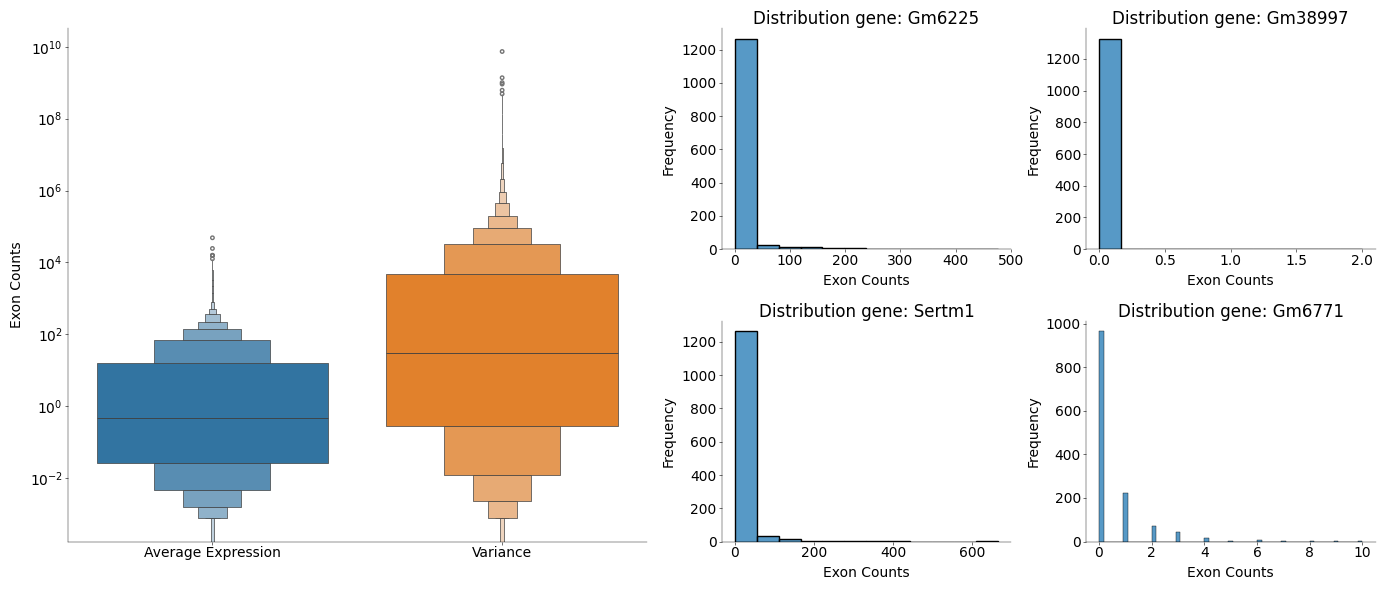

Avg exon counts of all genes: 37.74 (std: 344.96)
Avg number of cells that express a certain gene: 211.76 (std: 314.99)


The 5 most expressed genes on average:
1: CT010467.1: 	 48376.94 (std: 86179.43)
2: Gm26917: 	 24400.66 (std: 37173.28)
3: ERCC-00074: 	 15767.69 (std: 30343.80)
4: ERCC-00130: 	 15719.69 (std: 31804.46)
5: Snhg11: 	 15422.83 (std: 18551.54)
269 genes were not expressed at all


The 5 genes that were expressed by the most cells:
1: CT010467.1: 	 1327
2: mt-Rnr2: 	 1323
3: Lars2: 	 1322
4: Gm20388: 	 1321
5: Rn7s1: 	 1321


In [71]:
# Define the GridSpec layout
fig = plt.figure(figsize=(14, 6))
gs = plt.GridSpec(2, 3, width_ratios=[2, 1, 1], height_ratios=[1, 1])

ax_main = fig.add_subplot(gs[:, 0])
sns.boxenplot(data=[gene_means, gene_var], ax=ax_main)
ax_main.set_xticks([0, 1])
ax_main.set_xticklabels(["Average Expression", "Variance"])
ax_main.set_ylabel("Exon Counts")
ax_main.set_yscale("log")

np.random.seed(1)
random_genes = np.random.choice(data_exons.index, 4, replace=False)

axes = []
for i in range(2):
    for j in range(1, 3):
        ax = fig.add_subplot(gs[i, j])
        axes.append(ax)

for idx, gene in enumerate(random_genes):
    ax = axes[idx]
    sns.histplot(data_exons.loc[gene], kde=False, ax=ax)
    ax.set_title(f"Distribution gene: {gene}")
    ax.set_xlabel("Exon Counts")
    ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

# print some results
print(
    f"Avg exon counts of all genes: {np.mean(gene_means):.2f} (std: {np.std(gene_means):.2f})"
)
print(
    f"Avg number of cells that express a certain gene: {np.mean(n_cells_per_genes):.2f} (std: {np.std(n_cells_per_genes):.2f})"
)
print("\n")
print(f"The 5 most expressed genes on average:")
for i in range(5):
    print(
        f"{i+1}: {data_exons.index[gene_means_sorted_ids[i]]}: \t {gene_means[gene_means_sorted_ids[i]]:.2f} (std: {np.std(exonCounts[:, gene_means_sorted_ids[i]]):.2f})"
    )
print(f"{n_not_expressed} genes were not expressed at all")
print("\n")
print(f"The 5 genes that were expressed by the most cells:")
for i in range(5):
    print(
        f"{i+1}: {data_exons.index[n_cells_per_genes_sorted_ids[i]]}: \t {n_cells_per_genes[n_cells_per_genes_sorted_ids[i]]}"
    )

In [72]:
# cell specific expression

# how many different genes does a cell express on average
n_genes_per_cell = np.sum(data_exons.values > 0, axis=0)
n_genes_per_cell_sorted_ids = np.argsort(-n_genes_per_cell)

# get sequencing depth for each cell
seq_depth = np.sum(data_exons.values, axis=0)

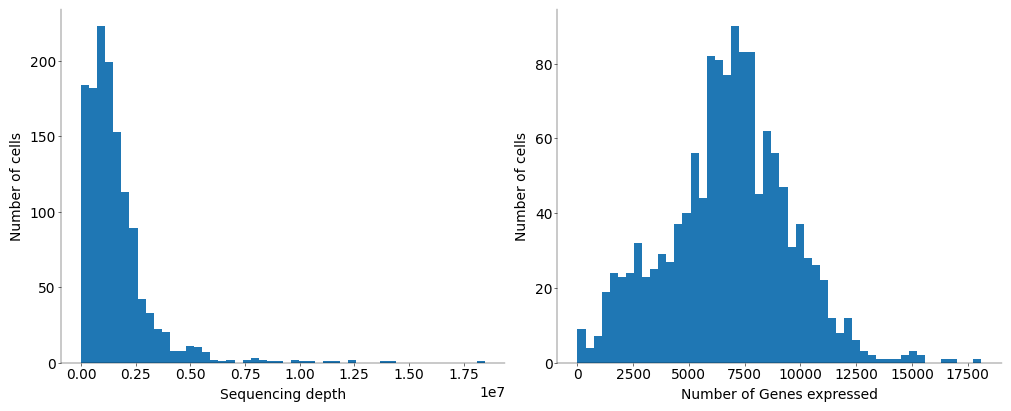

Average number of genes expressed over all cells: 6766.39 (std: 2742.47)
The 5 cells that expressed the most number of different genes:
0: 0610010F05Rik: 	 18118
1: 1110017D15Rik: 	 16845
2: 0610009L18Rik: 	 16310
3: 0610012G03Rik: 	 15527
4: 1110002J07Rik: 	 15372


The 5 cells that expressed the least number of different genes:
1: 1600014C23Rik: 	 5
2: 1700120G07Rik: 	 24
3: 1700120C18Rik: 	 26
4: 1700010B08Rik: 	 45
5: 1700080N15Rik: 	 69


In [73]:
# plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(seq_depth, bins=50)
ax[0].set_xlabel("Sequencing depth")
ax[0].set_ylabel("Number of cells")
ax[1].hist(n_genes_per_cell, bins=50)
ax[1].set_xlabel("Number of Genes expressed")
ax[1].set_ylabel("Number of cells")
plt.show()

# print results
print(
    f"Average number of genes expressed over all cells: {np.mean(n_genes_per_cell):.2f} (std: {np.std(n_genes_per_cell):.2f})"
)
print(f"The 5 cells that expressed the most number of different genes:")
for i in range(5):
    print(
        f"{i}: {data_exons.index[n_genes_per_cell_sorted_ids[i]]}: \t {n_genes_per_cell[n_genes_per_cell_sorted_ids[i]]}"
    )
print("\n")
print(f"The 5 cells that expressed the least number of different genes:")
for i in range(1, 6):
    print(
        f"{i}: {data_exons.index[n_genes_per_cell_sorted_ids[-i]]}: \t {n_genes_per_cell[n_genes_per_cell_sorted_ids[-i]]}"
    )

## 2) Normalize and Transform the Data ##

In [74]:
def cpm(counts):
    seq_depth = np.sum(counts, axis=1)
    normed = (counts / seq_depth[:, np.newaxis]) * 1e6
    return normed


def cpmedian(counts):
    seq_depth = np.sum(counts, axis=1)
    normed = counts / seq_depth[:, np.newaxis] * np.median(seq_depth)
    return normed


def rpkm(
    counts, lengths
):  ## Taken from https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch01.html
    """Calculate reads per kilobase transcript per million reads.

    RPKM = (10^9 * C) / (N * L)

    Where:
    C = Number of reads mapped to a gene
    N = Total mapped reads in the experiment
    L = Exon length in base pairs for a gene

    Parameters
    ----------
    counts: array, shape (N_genes, N_samples)
        RNAseq (or similar) count data where columns are individual samples
        and rows are genes.
    lengths: array, shape (N_genes,)
        Gene lengths in base pairs in the same order
        as the rows in counts.

    Returns
    -------
    normed : array, shape (N_genes, N_samples)
        The RPKM normalized counts matrix.
    """
    N = np.sum(counts, axis=0)  # sum each column to get total reads per sample
    L = lengths
    C = counts

    normed = 1e9 * C / (N[np.newaxis, :] * L[:, np.newaxis])

    return normed.T


# exonCounts = sklearn.preprocessing.normalize(exonCounts)
cpm = cpm(exonCounts)
cpmedian = cpmedian(exonCounts)
rpkm = rpkm(exonCounts.T, exonLengths)

In [75]:
## Transforms
def sqrt_transform(counts):
    return np.sqrt(counts)


def log_transform(counts):
    return np.log2(counts + 1)

## 3) Two-Dimensional visualization ##

In [76]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Condition            dist_corr  rank_corr  knn acc    density var
-----------------------------------------------------------------
Raw + None           0.81       0.75       0.41       15.10     
Raw + Log            0.37       0.14       0.12       24.47     
Raw + Sqrt           0.62       0.43       0.23       13.41     
CPM + None           0.86       0.77       0.42       10.15     
CPM + Log            0.43       0.15       0.10       15.58     
CPM + Sqrt           0.58       0.28       0.24       4.17      
CPMedian + None      0.86       0.77       0.42       10.09     
CPMedian + Log       0.42       0.14       0.10       14.63     
CPMedian + Sqrt      0.57       0.28       0.24       4.57      
RPKM + None          0.85       0.82       0.42       4.58      
RPKM + Log           0.31       0.07       0.07       24.63     
RPKM + Sqrt          0.81       0.74       0.28       8.52      


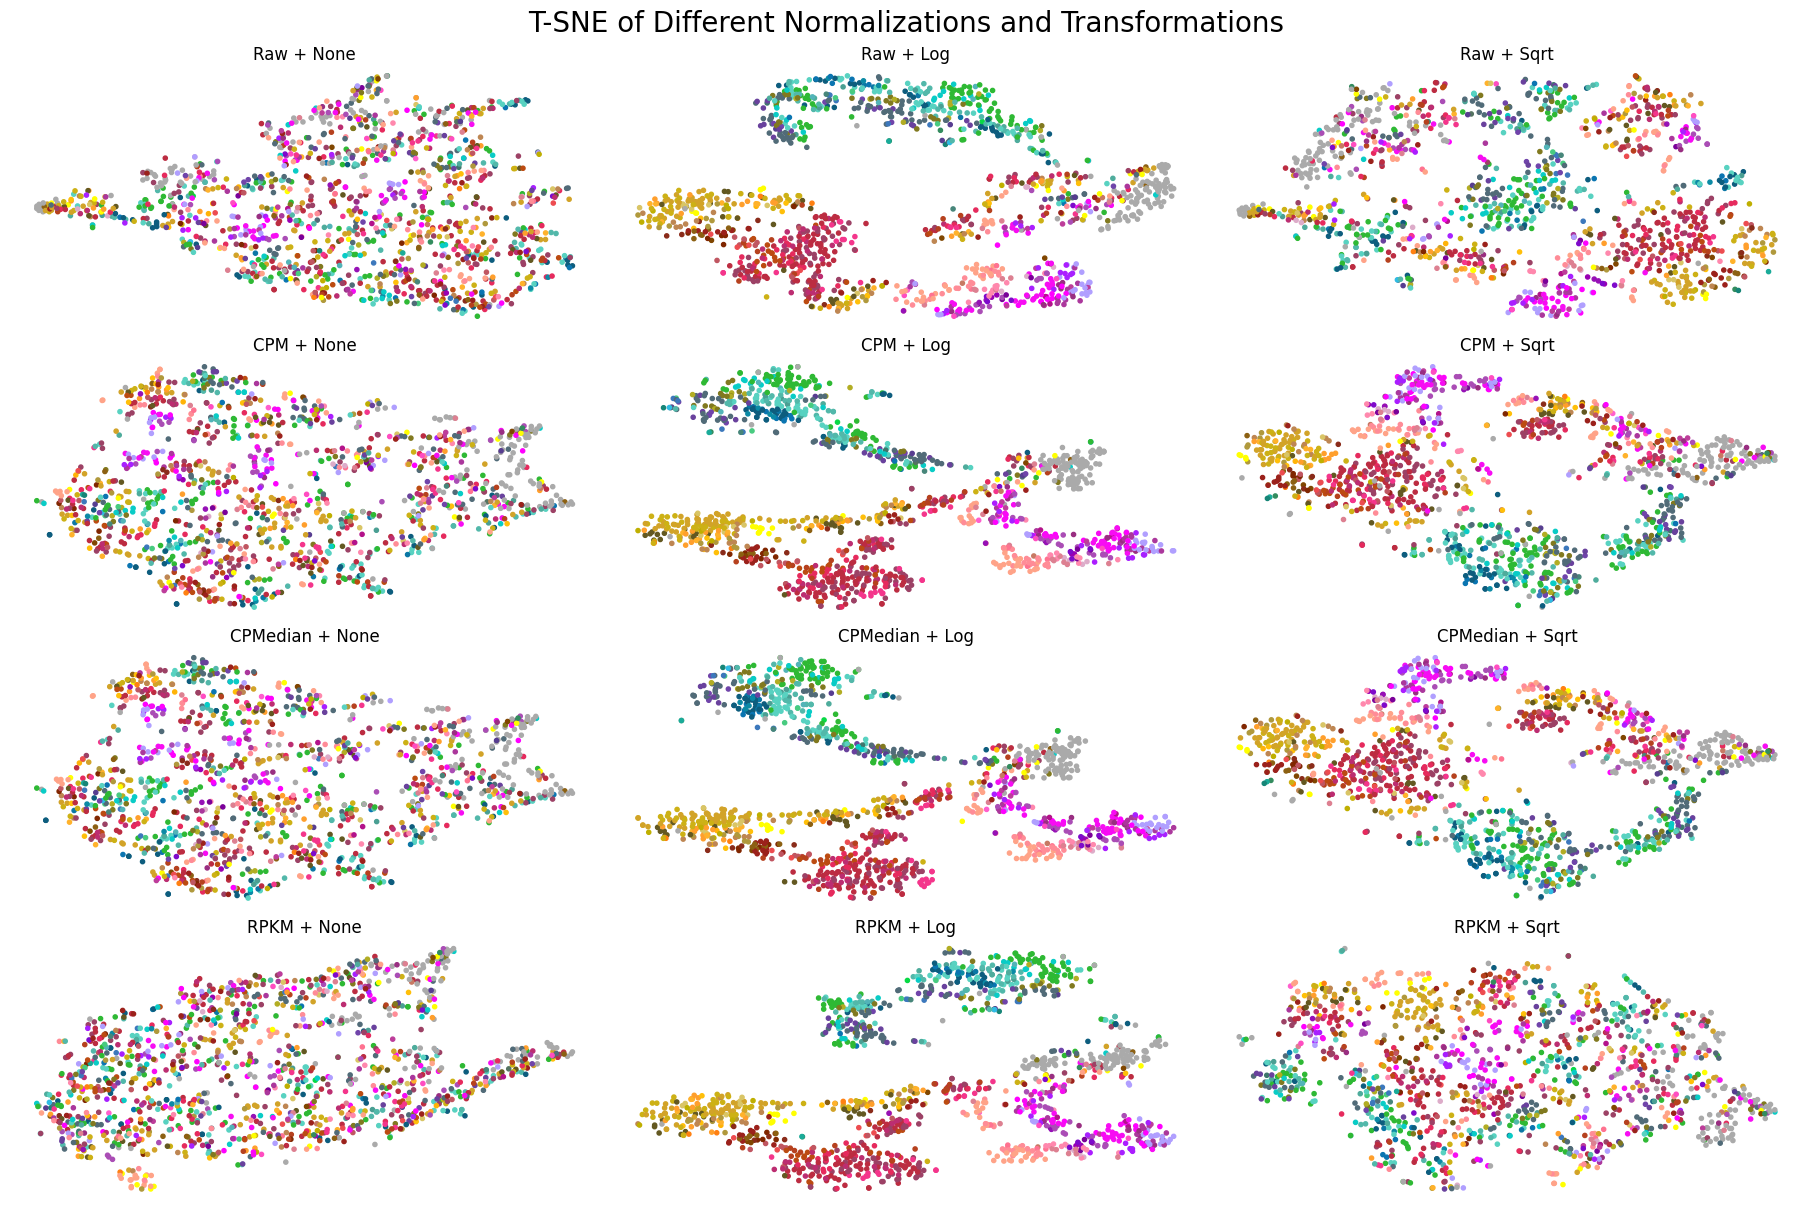

In [80]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import rankdata, spearmanr
from sklearn.metrics import silhouette_score


def distance_covariance(X, Y):
    n = X.shape[0]
    X -= X.mean(axis=0) + X.mean(axis=1)[:, np.newaxis] - X.mean()
    Y -= Y.mean(axis=0) + Y.mean(axis=1)[:, np.newaxis] - Y.mean()
    dcov = np.sqrt((X * Y).sum() / (n * n))
    return dcov


def distance_correlation(X, Y):
    dcov_XY = distance_covariance(X, Y)
    dcov_XX = distance_covariance(X, X)
    dcov_YY = distance_covariance(Y, Y)
    dcor = dcov_XY / np.sqrt(dcov_XX * dcov_YY)
    return dcor


normalizations = {
    "Raw": exonCounts,
    "CPM": cpm,
    "CPMedian": cpmedian,
    "RPKM": rpkm,
}

transformations = {
    "None": lambda x: x,
    "Log": log_transform,
    "Sqrt": sqrt_transform,
}

fig, axes = plt.subplots(
    len(normalizations), len(transformations), figsize=(18, 12)
)
fig.suptitle(
    "T-SNE of Different Normalizations and Transformations", fontsize=20
)

measures = np.zeros((len(normalizations), len(transformations), 4))

for i, (norm_name, norm_data) in enumerate(normalizations.items()):
    for j, (trans_name, trans_func) in enumerate(transformations.items()):
        data = norm_data[:, gene_var > np.sort(gene_var)[-501]]
        data_transformed = trans_func(data)
        pca_result = PCA(n_components=50).fit_transform(data_transformed)
        tsne = TSNE(n_components=2, perplexity=30)
        tsne_results = tsne.fit_transform(pca_result)

        ax = axes[i, j]
        ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_colors)
        ax.set_title(f"{norm_name} + {trans_name}", fontsize=12)
        ax.axis("off")

        # calculate pairwise (cell) distances in 2d and high dimensional space
        dist_hd = squareform(pdist(data))
        dist_ld = squareform(pdist(tsne_results))

        # calculate distance correlations
        dcor = distance_correlation(dist_hd, dist_ld)
        measures[i, j, 0] = dcor

        # calculate distance ranks
        ranks_hd = rankdata(dist_hd)
        ranks_ld = rankdata(dist_ld)
        # calculate correlation of ranks
        spearman_corr, _ = spearmanr(ranks_hd, ranks_ld)
        measures[i, j, 1] = spearman_corr

        # calculate the knn for each cell in high and low dimensional space
        k = 15
        knn_hd = np.array([np.argsort(x)[1 : k + 1] for x in dist_hd])
        knn_ld = np.array([np.argsort(x)[1 : k + 1] for x in dist_ld])
        # calculate the number of overlapping neighbors
        accuracy = np.sum(
            [len(set(x) & set(y)) for x, y in zip(knn_hd, knn_ld)]
        ) / (knn_hd.shape[0] * k)
        measures[i, j, 2] = accuracy

        # calculate point density variance
        mins = np.min(tsne_results, axis=0)
        maxs = np.max(tsne_results, axis=1)
        # kde = KernelDensity(kernel="gaussian", bandwidth=10).fit(tsne_results)
        x_grid = np.linspace(mins[0] - 1, maxs[0] + 1, 20)
        y_grid = np.linspace(mins[1] - 1, maxs[1] + 1, 20)
        densities = np.zeros(len(x_grid) * len(y_grid))
        pos = 0
        for x, _ in enumerate(x_grid[:-1]):
            for y, _ in enumerate(y_grid[:-1]):
                densities[pos] = np.sum(
                    (
                        (tsne_results[:, 0] >= x_grid[x])
                        & (tsne_results[:, 0] < x_grid[x + 1])
                        & (tsne_results[:, 1] >= y_grid[y])
                        & (tsne_results[:, 1] < y_grid[y + 1])
                    )
                )
                pos += 1
        measures[i, j, 3] = np.var(densities)


# print measures as table
print(
    f"{'Condition':<20} {'dist_corr':<10} {'rank_corr':<10} {'knn acc':<10} {'density var':<10}"
)
print("-" * 65)
for i, (norm_name, norm_data) in enumerate(normalizations.items()):
    for j, (trans_name, trans_func) in enumerate(transformations.items()):
        condition = f"{norm_name} + {trans_name}"
        print(
            f"{condition:<20} {measures[i, j, 0]:<10.2f} {measures[i, j, 1]:<10.2f} {measures[i, j, 2]:<10.2f} {measures[i, j, 3]:<10.2f}"
        )

In [78]:
import umap.umap_ as umap

Condition            dist_corr  rank_corr  knn acc    density var
-----------------------------------------------------------------
Raw + None           0.82       0.77       0.35       0.35      
Raw + Log            0.63       0.40       0.26       20.15     
Raw + Sqrt           0.76       0.58       0.29       6.93      
CPM + None           0.86       0.76       0.38       7.77      
CPM + Log            0.66       0.48       0.29       4.67      
CPM + Sqrt           0.75       0.50       0.34       11.05     
CPMedian + None      0.86       0.75       0.38       6.00      
CPMedian + Log       0.67       0.47       0.29       72.09     
CPMedian + Sqrt      0.74       0.49       0.34       10.07     
RPKM + None          0.87       0.84       0.39       5.95      
RPKM + Log           0.66       0.46       0.30       92.18     
RPKM + Sqrt          0.83       0.65       0.33       2.85      


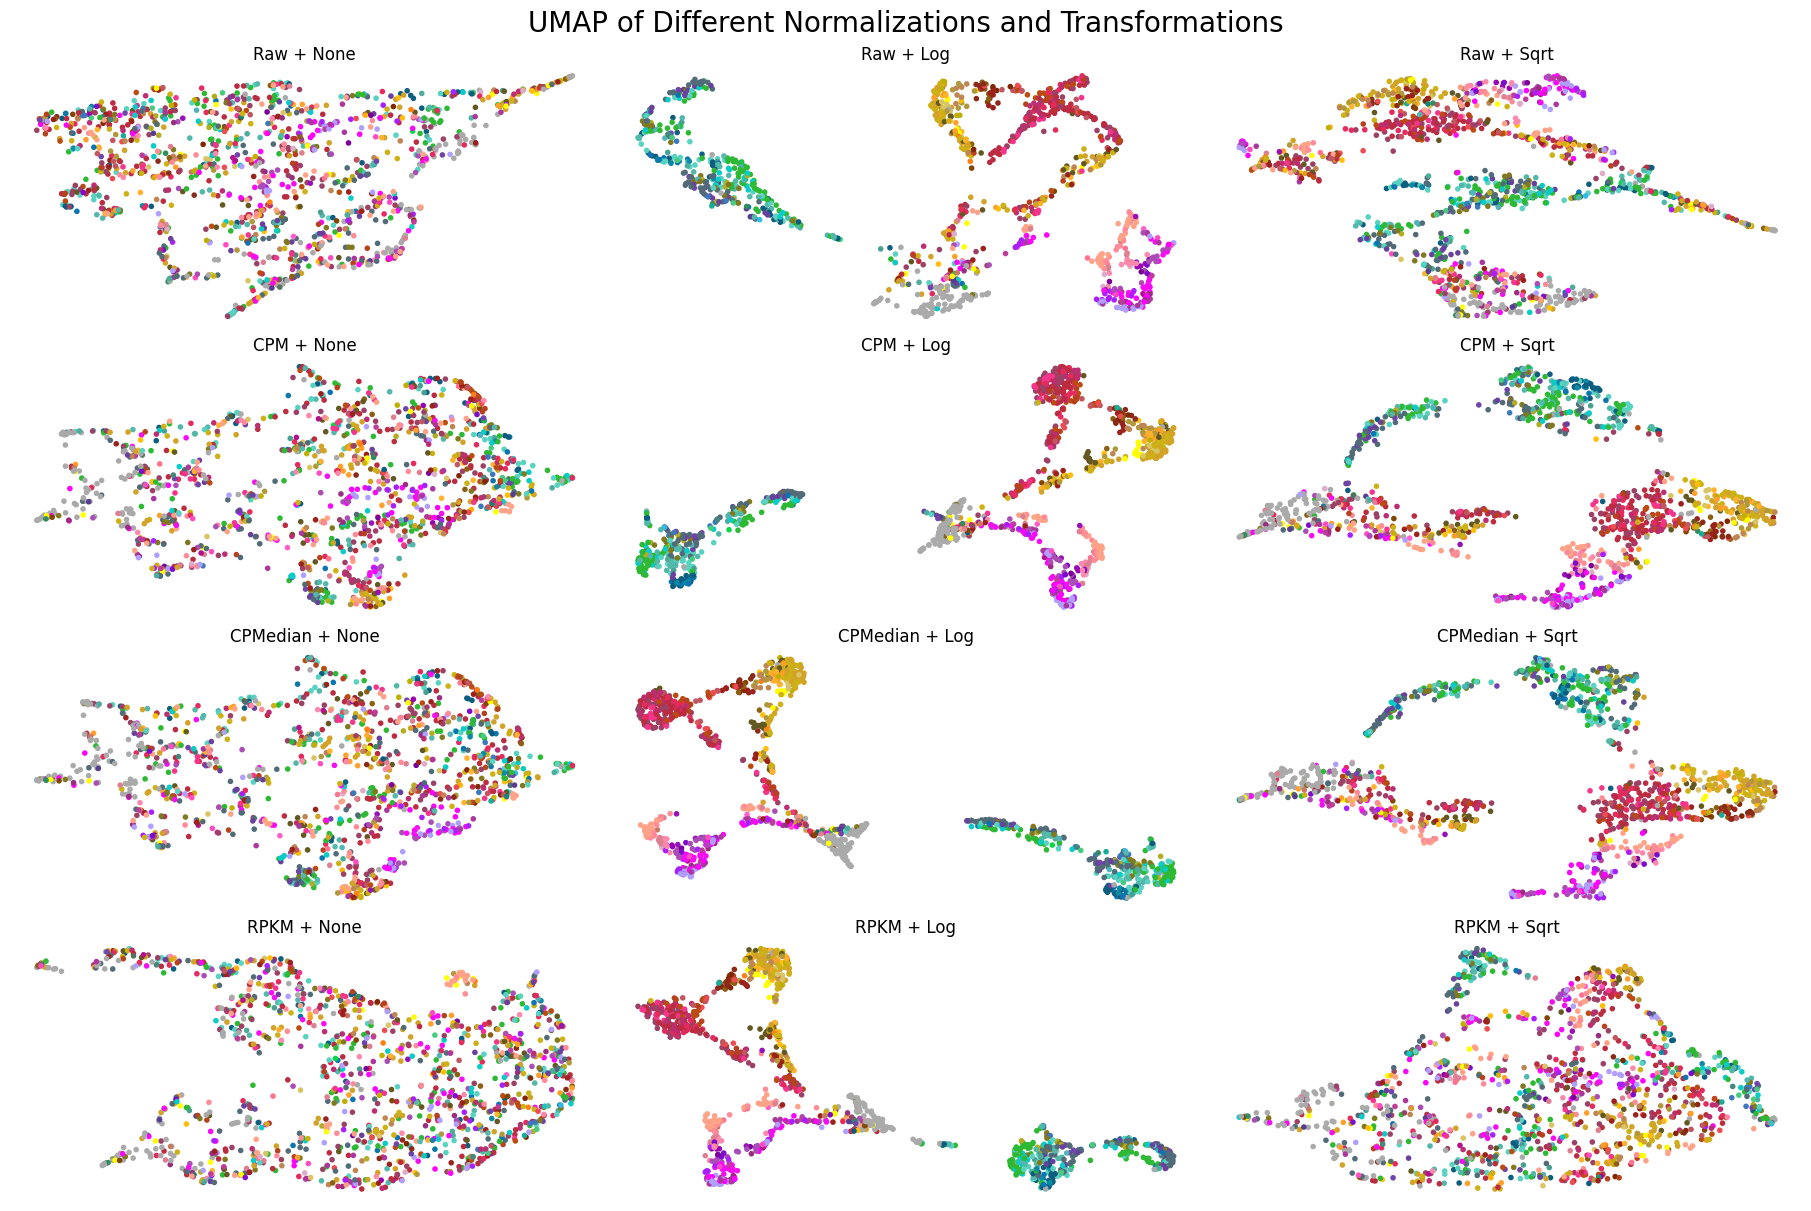

In [79]:
normalizations = {
    "Raw": exonCounts,
    "CPM": cpm,
    "CPMedian": cpmedian,
    "RPKM": rpkm,
}

transformations = {
    "None": lambda x: x,
    "Log": log_transform,
    "Sqrt": sqrt_transform,
}

fig, axes = plt.subplots(
    len(normalizations), len(transformations), figsize=(18, 12)
)
fig.suptitle(
    "UMAP of Different Normalizations and Transformations", fontsize=20
)

measures = np.zeros((len(normalizations), len(transformations), 4))

for i, (norm_name, norm_data) in enumerate(normalizations.items()):
    for j, (trans_name, trans_func) in enumerate(transformations.items()):
        data = norm_data[:, gene_var > np.sort(gene_var)[-501]]
        data_transformed = trans_func(data)
        pca_result = sklearn.decomposition.PCA(n_components=50).fit_transform(
            data_transformed
        )
        umap_model = umap.UMAP()
        umap_results = umap_model.fit_transform(pca_result)

        ax = axes[i, j]
        ax.scatter(umap_results[:, 0], umap_results[:, 1], c=cluster_colors)
        ax.set_title(f"{norm_name} + {trans_name}", fontsize=12)
        ax.axis("off")

        # calculate pairwise (cell) distances in 2d and high dimensional space
        dist_hd = squareform(pdist(data_transformed))
        dist_ld = squareform(pdist(umap_results))

        # calculate distance correlations
        dcor = distance_correlation(dist_hd, dist_ld)
        measures[i, j, 0] = dcor

        # calculate distance ranks
        ranks_hd = rankdata(dist_hd)
        ranks_ld = rankdata(dist_ld)
        # calculate correlation of ranks
        spearman_corr, _ = spearmanr(ranks_hd, ranks_ld)
        measures[i, j, 1] = spearman_corr

        # calculate the knn for each cell in high and low dimensional space
        k = 15
        knn_hd = np.array([np.argsort(x)[1 : k + 1] for x in dist_hd])
        knn_ld = np.array([np.argsort(x)[1 : k + 1] for x in dist_ld])
        # calculate the number of overlapping neighbors
        accuracy = np.sum(
            [len(set(x) & set(y)) for x, y in zip(knn_hd, knn_ld)]
        ) / (knn_hd.shape[0] * k)
        measures[i, j, 2] = accuracy

        # calculate point density variance
        mins = np.min(umap_results, axis=0)
        maxs = np.max(umap_results, axis=1)
        # kde = KernelDensity(kernel="gaussian", bandwidth=10).fit(tsne_results)
        x_grid = np.linspace(mins[0] - 1, maxs[0] + 1, 20)
        y_grid = np.linspace(mins[1] - 1, maxs[1] + 1, 20)
        densities = np.zeros(len(x_grid) * len(y_grid))
        pos = 0
        for x, _ in enumerate(x_grid[:-1]):
            for y, _ in enumerate(y_grid[:-1]):
                densities[pos] = np.sum(
                    (
                        (umap_results[:, 0] >= x_grid[x])
                        & (umap_results[:, 0] < x_grid[x + 1])
                        & (umap_results[:, 1] >= y_grid[y])
                        & (umap_results[:, 1] < y_grid[y + 1])
                    )
                )
                pos += 1
        measures[i, j, 3] = np.var(densities)


# print measures as table
print(
    f"{'Condition':<20} {'dist_corr':<10} {'rank_corr':<10} {'knn acc':<10} {'density var':<10}"
)
print("-" * 65)
for i, (norm_name, norm_data) in enumerate(normalizations.items()):
    for j, (trans_name, trans_func) in enumerate(transformations.items()):
        condition = f"{norm_name} + {trans_name}"
        print(
            f"{condition:<20} {measures[i, j, 0]:<10.2f} {measures[i, j, 1]:<10.2f} {measures[i, j, 2]:<10.2f} {measures[i, j, 3]:<10.2f}"
        )


plt.show()

## To Dos

- Inspect the data schön machen
- 2)3) Different transforms for the 2d Visualization
- 3) Quantitative measures for tsne and umap
- den Rest
- Einheiten Soma depth